<a href="https://colab.research.google.com/github/APasu12/ReVolt-Marketplace/blob/main/ENGR_1050_Final_Project_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General Information and Import Statements

In [ ]:
# Copyright: Aditya Pasumarthi

import math
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_distances
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import groupby
from scipy.stats import kruskal
from scipy.stats import shapiro

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
import matplotlib.patches as mpatches
import scipy.stats as stats

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Part 1: Data Cleaning/Pre-Processing

In [ ]:
def convert_data( link ):
  """Converts link to dataframe"""
  healthData = pd.read_csv(link, header=0) # First column in dataframe represents column names
  df = pd.DataFrame(healthData)
  df.head()
  return df

def clean_dataset( df ):
  """Rows with "Null" values are not included in the returned clean dataframe"""
  finaldf = df.dropna() # Drop NaN values
  return finaldf

def filter_entries( cleaned_df ):
  """Extracts rows with Manufacter Name = "Overall" """
  totseries = []
  colNumber = 0
  for i in range( 0, len(cleaned_df.columns) ): # Finds the column index of "Mftr_Name"
    if cleaned_df.columns[i] == "Mftr_Name":
      colNumber = i
  for i in range( 0, len(cleaned_df["Mftr_Name"]) ): # Include only rows where the Mftr_Name == "Overall"
    if cleaned_df.iloc[i, colNumber] == "Overall":
      myseries = cleaned_df.iloc[i,:]
      totseries.append(myseries)
  finalseries = pd.DataFrame(totseries)
  return finalseries

Part 2: Determine Which Drugs Change Price Together

In [ ]:
def weighted_year_columnNum( df ):
  """Finds the column numbers for average spending per dosage unit"""
  col_2018 = 0
  col_2019 = 0
  col_2020 = 0
  col_2021 = 0
  col_2022 = 0
  for i in range( 0, len(df.columns) ): # Finds column indices of specified column names
    if df.columns[i] == "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018":
      col_2018 = i
    elif df.columns[i] == "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019":
      col_2019 = i
    elif df.columns[i] == "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020":
      col_2020 = i
    elif df.columns[i] == "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021":
      col_2021 = i
    elif df.columns[i] == "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022":
      col_2022 = i
  return [col_2018, col_2019, col_2020, col_2021, col_2022]

def normalize_prices( df, colNumbers ):
  """Creates a new dataframe of the normalized versions of the drug time series"""
  normal_col = ["Brnd_Name", "Norm_2018", "Norm_2019", "Norm_2020", "Norm_2021", "Norm_2022"]
  tot_list = []
  for i in range(0, df.shape[0] ):
    price_list = [] # The five actual price values are added to this list
    price_list.append(float(df.iloc[i, colNumbers[0]]))
    price_list.append(float(df.iloc[i, colNumbers[1]]))
    price_list.append(float(df.iloc[i, colNumbers[2]]))
    price_list.append(float(df.iloc[i, colNumbers[3]]))
    price_list.append(float(df.iloc[i, colNumbers[4]]))
    for j in range(0, len(price_list)): # The five z-scores then replace the values
      value = price_list[j]
      z_score = ( value - np.mean(price_list) ) / np.std(price_list)
      price_list[j] = z_score

    price_list.insert(0, df.iloc[i,0]) # Insert drug name at beginning of list
    tot_list.append(price_list)
  finaldf = pd.DataFrame(tot_list, columns = normal_col )
  return finaldf

# Instead of calculating the actual differences in values (euclidean distance), we will calculate the cosine distance since all our data is already normalized
# Cosine Distance is more relavant for analyzing the shape of the trend, which is the goal of this section, while euclidean distance is more applicable if we want to compare the actual difference between the normalized prices
def cosine_matrix( df ):
  """Creates a matrix with the cosine distances between the normalized prices"""
  df = df.drop_duplicates(subset="Brnd_Name")
  data_df = df[["Norm_2018", "Norm_2019", "Norm_2020", "Norm_2021", "Norm_2022"]]
  data_df = data_df.dropna()
  co_distance_matrix = cosine_distances(data_df) # Each entry (i,j) represents the cosine distance between drug "i" and drug "j"
  distance_df = pd.DataFrame(co_distance_matrix, index = df["Brnd_Name"], columns = df["Brnd_Name"])
  return distance_df

def one_kNN_similarity( distance_df, drugName, kNN ): # Number of k-Nearest Neighbors is second input
  """Returns the user-specified number of k-nearest neighbors to the user-specified drug brand name"""
  drug_distances = distance_df.loc[drugName]

  # ChatGPT helped with next two lines
  if isinstance(drug_distances, pd.DataFrame):
    drug_distances = pd.Series(drug_distances.iloc[0]) # Convert to series if not already a series

  drug_distances = drug_distances.drop(drugName) # Starts from column index = 1 (we are excluding the drug itself since it has a cosine distance of 0 with itself)
  closest = drug_distances.nsmallest(kNN)
  kNN_names = list(closest.index)

  return kNN_names # After sorting, the first value will be 0 (all drugs have a cosine similarity of 0 with themselves)

def tot_kNN_similarity( normalized_df, kNN ): # Number of k-Nearest Neighbors is second input
  """Returns the user-specified number of k-nearest neighbors for all drug brand names"""
  distance_df = cosine_matrix( normalized_df )
  normalized_df = normalized_df.set_index("Brnd_Name")
  mydict = {} # Create a dictionary to store kNN names
  for drug_name in normalized_df.index:
    mydict[drug_name] = one_kNN_similarity(distance_df, drug_name, kNN) # value = kNN drug names
  columns = []
  for i in range(1, kNN+1): # Create dataframe column names
    columns.append( f"kNN {i}" )
  finaldf = pd.DataFrame.from_dict(mydict, columns = columns, orient = "index") # Google Search
  # print(finaldf)
  !pip install openpyxl
  finaldf.to_excel("k-Nearest Neighbors.xlsx", index = True, index_label = "Drug Name")
  return finaldf


Part 3: Predicting Future Price Trends Using Regularization

In [ ]:
def extract_CAGR( df ):
  """Extract Compound Annual Growth Rate (2018-2022)"""
  """This function was used as practice"""
  col_CAGR = 0
  for i in range( 0, len(df.columns) ): # Find column index
    if df.columns[i] == "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22":
      col_CAGR = i
  return col_CAGR

def find_convert_data( df ):
  """Creates a list containing dataframes with each row representing one drug's colNames data"""
  tot_list = []
  drug_names = df["Brnd_Name"] # DataFrame of drug brand names
  colNames = ["Drug Name", "Year", "Per Claim", "Per Beneficiary", "Per Dosage", "CAGR"]
  for row in range(0, df.shape[0]):
    drug_list = [] # Nested list
    for i in range(2018, 2023): # Find column numbers for specified column names (2018-2022 data)
      year_str = str(i)
      colClaim = df["Avg_Spnd_Per_Clm_" + year_str]
      colBene = df["Avg_Spnd_Per_Bene_" + year_str]
      colPrice = df["Avg_Spnd_Per_Dsg_Unt_Wghtd_" + year_str]
      colCAGR = df["CAGR_Avg_Spnd_Per_Dsg_Unt_18_22"]

      # Create a list of the drug's year's relevant information
      each_drug = [drug_names.iloc[row], i, colClaim.loc[df.index[row]], colBene.loc[df.index[row]], colPrice.loc[df.index[row]], colCAGR.loc[df.index[row]]]
      drug_list.append(each_drug)
    mid_df = pd.DataFrame(drug_list, columns = colNames)
    tot_list.append(mid_df) # Each element of tot_list is a dataframe
  return tot_list

def calculate_dosage( mylist ):
  """The function first trains the 2018-2022 data, predicts 2023 and 2024 claims and beneficiary data, and then predicts 2023 and 2024 dosage data"""
  future_data = []
  for drug_data in mylist: # Iterate through each drug's dataframe in mylist
    X = drug_data[["Per Claim", "Per Beneficiary"]]
    Y = drug_data["Per Dosage"]

    # Training the data
    xTrain, xTest, yTrain, yTest = train_test(X, Y)
    tuple1 = ridgeReg( xTrain, xTest, yTrain, yTest )
    tuple2 = lassoReg( xTrain, xTest, yTrain, yTest )
    tuple3 = elasticReg( xTrain, xTest, yTrain, yTest )
    name, the_list = minError( tuple1, tuple2, tuple3 )
    # print("The best model to predict dosage data is a", name, "model")

    future_claims, name_claims, r2_claims = predict_claims( drug_data ) # output in the form of np.array([2023 value, 2024 value])
    future_bene, name_bene, r2_bene = predict_bene( drug_data ) # output in the form of np.array([2023 value, 2024 value])
    combined_future = np.column_stack((future_claims, future_bene)) # Google Search

    # ChatGPT helped with next three lines
    if name == "Ridge":
      ridgeModel = Ridge().fit(xTrain, yTrain)
      future_dosage = ridgeModel.predict(combined_future)
    elif name == "Lasso":
      lassoModel = Lasso().fit(xTrain, yTrain)
      future_dosage = lassoModel.predict(combined_future)
    else:
      elasticModel = ElasticNet().fit(xTrain, yTrain)
      future_dosage = elasticModel.predict(combined_future)

    future_data.append([drug_data.iloc[0,0], name_claims, r2_claims, future_claims[0], future_claims[1], name_bene, r2_bene, future_bene[0], future_bene[1], future_dosage[0], future_dosage[1]])

  columnNames = ["Drug Name", "Model to Predict Claims", "R-Squared Value - Claims", "2023 Claims Prediction", "2024 Claims Prediction", "Model to Predict Beneficiaries", "R-Squared Value - Beneficiaries", "2023 Beneficiary Prediction", "2024 Beneficiary Prediction", "2023 Dosage Prediction", "2024 Dosage Prediction"]
  finaldf = pd.DataFrame(future_data, columns = columnNames)
  print(finaldf.head())
  !pip install openpyxl
  finaldf.to_excel("2023 and 2024 Predicted Dosage Data.xlsx", index=False)

  return finaldf

"""
def current_values( name, params ):
  "Calculates dosage trend for 2018, 2019, 2020, 2021, and 2022 data based on the selected function"
  future_years = np.array([1,2,3,4,5])
  if name == "logarithmic":
    current_dosage = logarithmic(future_years, *params)
  else:
    current_dosage = linear(future_years, *params)
  return current_dosage
"""

def predict_claims( drug_df ):
  """Predicts 2023 and 2024 per claims data for each drug"""
  X = drug_df["Per Claim"]
  name, r2, params = fit( X ) # finds parameters
  future_array = predict_future( name, params ) # 2023 and 2024 drug price predictions
  return (future_array, name, r2)

def predict_bene( drug_df ):
  """Predicts 2023 and 2024 per beneficiary data for each drug"""
  X = drug_df["Per Beneficiary"]
  name, r2, params = fit( X ) # finds parameters
  future_array = predict_future( name, params ) # 2023 and 2024 drug price predictions
  return (future_array, name, r2)

def predict_future( name, params ):
  """Predicts data for next two years (2023 and 2024) based on the selected function"""
  future = np.array([6,7]) # Represent 2023 and 2024 since year 1 = 2018
  if name == "mean of timeframe":
    future_predict = np.array([params[0], params[0]]) # Predicting that the 2023 and 2024 values will just be approximately the mean of the 2018-2022 values
  elif name == "logarithmic":
    future_predict = logarithmic(future, *params)
  elif name == "linear":
    future_predict = linear(future, *params)
  else:
    future_predict = exponential(future, *params)
  return future_predict

def logarithmic(x, a, b):
  """Calculates the logarithmic equation based on inputted data and coefficients"""
  y = a*(np.log(x)) + b
  return y

def linear(x, a, b):
  """Calculates the linear equation based on inputted data and coefficients"""
  y = a*x + b
  return y

def exponential(x, a, b):
  """Calculates the linear equation based on inputted data and coefficients"""
  return a * np.exp(b*x)

def fit( data_df ):
  """Fits the data for each drug for years 2018-2022"""
  time = np.array([1, 2, 3, 4, 5]) # Years 2018-2022
  data_onedim = data_df.to_numpy() # Converts inputted dataframe into numpy array (Google Search)

  # Logarithmic Fit
  params1, pcov1 = curve_fit(logarithmic, time, data_onedim)
  log_predict = logarithmic(data_onedim, *params1)
  r2_log = r2_score(data_onedim, log_predict)

  # Linear Fit
  params2, pcov2 = curve_fit(linear, time, data_onedim)
  linear_predict = linear(data_onedim, *params2)
  r2_linear = r2_score(data_onedim, linear_predict)

  # Exponential Fit
  params3, pcov3 = curve_fit(exponential, time, data_onedim)
  exp_predict = logarithmic(data_onedim, *params3)
  r2_exp = r2_score(data_onedim, exp_predict)

  if max(r2_log, r2_linear, r2_exp) < 0.0:
    return ("mean of timeframe", 0, [np.mean(data_onedim)])
  elif max(r2_log, r2_linear, r2_exp) == r2_log:
    return ("logarithmic", r2_log, params1)
  elif max(r2_log, r2_linear, r2_exp) == r2_linear:
    return ("linear", r2_linear, params2)
  else:
    return ("exponential", r2_exp, params3)

def train_test( X, Y ):
  """Trains the X and Y data"""
  xTrain, xTest, yTrain, yTest = train_test_split(X,Y, test_size = 0.25, random_state = 40) # Did not choose np.random.randint since we need reproducible results each time the program is run
  return xTrain, xTest, yTrain, yTest

def ridgeReg( xTrain, xTest, yTrain, yTest ):
  """Determines coefficients, intercept, and MSE for Ridge Regression"""
  ridgereg = Ridge(alpha=1)
  ridgereg.fit(xTrain,yTrain) # Fit xTrain and yTrain
  coef = ridgereg.coef_ # Determine coefficients
  intercept = ridgereg.intercept_
  MSE = np.sqrt( mean_squared_error(yTest, ridgereg.predict(xTest)) ) # Determine mean square error
  return [coef, intercept, MSE]

def lassoReg( xTrain, xTest, yTrain, yTest ):
  """Determines coefficients, intercept, and MSE for Lasso Regression"""
  lassoreg = Lasso(alpha=1)
  lassoreg.fit(xTrain,yTrain) # Fit xTrain and yTrain
  coef = lassoreg.coef_ # Determine coefficients
  intercept = lassoreg.intercept_
  MSE = np.sqrt( mean_squared_error(yTest, lassoreg.predict(xTest)) ) # Determine mean square error
  return [coef, intercept, MSE]

def elasticReg( xTrain, xTest, yTrain, yTest ):
  """Determines coefficients, intercept, and MSE for Elastic Regression"""
  eNet = ElasticNet(alpha = .6) # 60% Lasso and 40% Ridge
  efit = eNet.fit(xTrain, yTrain) # Fit xTrain and yTrain
  coef = efit.coef_ # Determine coefficients
  intercept = efit.intercept_
  MSE = np.sqrt( mean_squared_error(yTest, efit.predict(xTest)) ) # Determine mean square error
  return [coef, intercept, MSE]

def minError( tuple1, tuple2, tuple3 ):
  """Determines which of Ridge, Lasso, and Elastic has the smallest Mean Squared Error (MSE)"""
  num1 = tuple1[2] # MSE of Ridge
  num2 = tuple2[2] # MSE of Lasso
  num3 = tuple3[2] # MSE of Elastic
  minNum = min(num1, num2, num3) # Calculates minimum
  if minNum == num1:
    return "Ridge", tuple1
  elif minNum == num2:
    return "Lasso", tuple2
  else:
    return "Elastic", tuple3

Part 4: Compare Drugs with Abnormal Prices

We will use Avg_Spnd_Per_Dsg_Unt_Wghtd_2022 prices only

In [ ]:
def calculate_zscore( column_df, rowNum ):
  """Calculating z-score for each drug"""

  # Using numpy to find mean and standard deviation
  mean_price = np.mean(column_df)
  std_price = np.std(column_df)
  drug_price = column_df.iloc[rowNum]
  z_score = ( drug_price - mean_price ) / std_price
  return float(z_score)

def outlier_detection( filtered_df ):
  """Determines which drugs are outliers based on 2022 dosage unit price"""
  """Any drug with a z-score > |2| will be considered an outlier (alpha = 0.05)"""
  prices_2022 = filtered_df["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"] # Only looking at this column
  drugNames = filtered_df.index.to_list()
  outlier_list = []
  threshold = 2 # z-score threshold
  for i in range(0, filtered_df.shape[0]):
    z_score = calculate_zscore( prices_2022, i )
    if z_score >= threshold or z_score <= -threshold:
        drug_name = drugNames[i]
        outlier_list.append( drug_name )
  return outlier_list

"""
def compute_correlations( filtered_df ):
  "Computes correlations for z-scores with Total Claims/Beneficiaries and Average Claims/Beneficiaries"
  prices_2022 = filtered_df["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"]
  z_scores = []
  for i in range(0, prices_2022[0]):
    z_scores.append(calculate_zscore( prices_2022, i))

  selected_features = filtered_df["Tot_Clms_2022", "Avg_Spnd_Per_Clm_2022", "Tot_Benes_2022", "Avg_Spnd_Per_Bene_2022", "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22"]

  # Correlation with Total and Average Beneficiaries
  # Hypothesis: Drugs that have very high prices (extremely high z-score) are used by fewer people

  tot_bene = df["Tot_Benes_2022"]
  avg_bene = df["Avg_Spnd_Per_Bene_2022"]
  corr_tot_bene = sp.stats.pearsonr(z_scores, tot_bene)
  corr_avg_bene = sp.stats.pearsonr(z_scores, avg_bene)

  # Correlation with Total and Average Claims
  # Hypothesis: Drugs that have very high prices (extremely high z-score) are used by fewer people

  tot_clm = df["Tot_Clms_2022"]
  avg_clm = df["Avg_Spnd_Per_Clm_2022"]
  corr_tot_clm = sp.stats.pearsonr(z_scores, tot_clm)
  corr_avg_clm = sp.stats.pearsonr(z_scores, avg_clm)

  return
"""

def df_above5( cleaned_df ):
  """Creates a new dataframe that contains rows from the inputted dataframe if the Manufacterer produces >= 5 drugs"""
  manufact = cleaned_df["Mftr_Name"].value_counts() # Google Search
  list_above5 = []
  for name, freq in manufact.items():
    if freq >= 5 and name != "Overall": # Excluding Mftr_Name = "Overall" rows
      list_above5.append(name)
  colMftr = cleaned_df["Mftr_Name"]

  tot_list = []
  for i in range( 0, colMftr.shape[0] ):
    if colMftr.iloc[i] in list_above5: # Add the row if manufacturer name is in list_above5
      tot_list.append( cleaned_df.iloc[i, :] )
  finaldf = pd.DataFrame(tot_list)
  return finaldf

def kruskal_wallis_htest( prepared_df ):
  """Performs that Kruskal-Wallis HTest on the dataframe since ANOVA cannot be used (data is non-normal)"""

  # Null Hypothesis: Manufacturers that produce >= 5 drugs price drugs similarly
  # Alternative Hypothesis: Manufacturers that produce >= 5 drugs price drugs differently
  # Kruskal-Wallis does not test differences in means. It tests differences in medians, spread, and distribution shape

  grouped = prepared_df.groupby("Mftr_Name") # Google Search
  # This is a collection of dataframes. Each drug has a corresponding dataframe that holds all of its drugs prices

  tot_list_price = []
  for name, price_df in grouped:
    values = price_df["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"] # We are only testing 2022 prices
    values = values.dropna() # Google Search (we want non-Null values)
    if len(values) > 1: # Ensures we are actually pulling data
      tot_list_price.append(values)
  h_stat, p_value = kruskal(*tot_list_price) # I didn't know how to unpack a list, so ChatGPT helped with this line
  return p_value

def plot_boxplots_top10( cleaned_df ):
  """Plots a boxplots for top 10 manufacturers by median per dosage unit price in 2022"""
  df_set = df_above5( cleaned_df )
  mftrName = df_set["Mftr_Name"].to_list()

  # Finding Top 10 Manufacturers by median per dosage unit price
  manufact = df_set.groupby("Mftr_Name")
  median_series = manufact["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"].median() # Google Search (.median() returns a series, not a dataframe)

  top10_median = median_series.sort_values(ascending = False).head(10) # Top 10 largest values
  top10_median_mftr = top10_median.index
  new_list = []
  for i in range(0, len(mftrName)):
    if mftrName[i] in top10_median_mftr: # Check if manufacturer name is in top10_median_mftr first
      new_list.append(df_set.iloc[i, :])
  top10_df = pd.DataFrame(new_list)
  top10_df = top10_df.sort_values(by=["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"], ascending = True)

  # This creates 3 subplots in a new figure
  fig, axes = plt.subplots(3, 1, figsize=(12, 10))

  # This plots top 10 manufacturers
  sns.boxplot(data=top10_df, x="Mftr_Name", y="Avg_Spnd_Per_Clm_2022", ax=axes[0])
  sns.boxplot(data=top10_df, x="Mftr_Name", y="Avg_Spnd_Per_Bene_2022", ax=axes[1])
  sns.boxplot(data=top10_df, x="Mftr_Name", y="Avg_Spnd_Per_Dsg_Unt_Wghtd_2022", ax=axes[2])

  # Titles for each subplot
  axes[0].set_title("Average Spending Per Claim (Top 10)")
  axes[1].set_title("Average Spending Per Beneficiary (Top 10)")
  axes[2].set_title("Average Spending Per Dosage Unit (Top 10)")

  # Entire figure title
  fig.suptitle("Overall Drug Spending Analysis for Top 10 Manufacturers by Median Dosage Unit Price", fontsize=16)

  # Google Search (next two lines)
  for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

  # plt.yscale("log")  # Large price range
  plt.tight_layout()
  plt.show()
  return

def plot_boxplots_topbot5( cleaned_df ):
  """Plots a boxplot for the top 5 and bottom 5 extremes drugs by median per dosage unit price in 2022"""
  df_set = df_above5( cleaned_df )
  mftrName = df_set["Mftr_Name"].to_list()

  # Finding Top 10 Manufacturers by median per dosage unit price
  manufact = df_set.groupby("Mftr_Name")
  median_series = manufact["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"].median() # Google Search (.median() returns a series, not a dataframe)

  # Finding Top 5 and Bottom 5 Median Extremes for manufacturers
  top5_median = median_series.sort_values(ascending = False).head(5)
  top5_median_mftr = top5_median.index

  bot5_median = median_series.sort_values(ascending = True).head(5)
  bot5_median_mftr = bot5_median.index

  topbot = pd.concat([top5_median, bot5_median])
  print(topbot)
  new_list = []
  for i in range(0, len(mftrName)):
    if mftrName[i] in topbot: # Check if manufacturer name is in topbot first
      new_list.append(df_set.iloc[i, :])
  topbot10_df = pd.DataFrame(new_list)
  topbot10_df = topbot10_df.sort_values(by=["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"], ascending = True)

  # This creates 3 subplots in a new figure
  fig, axes = plt.subplots(3, 1, figsize=(12, 10))

  # This plots top 5 and bottom 5 manufacturers
  sns.boxplot(data=topbot10_df, x="Mftr_Name", y="Avg_Spnd_Per_Clm_2022", ax=axes[0])
  sns.boxplot(data=topbot10_df, x="Mftr_Name", y="Avg_Spnd_Per_Bene_2022", ax=axes[1])
  sns.boxplot(data=topbot10_df, x="Mftr_Name", y="Avg_Spnd_Per_Dsg_Unt_Wghtd_2022", ax=axes[2])

  # Titles for each subplot
  axes[0].set_title("Average Spending Per Claim")
  axes[1].set_title("Average Spending Per Beneficiary")
  axes[2].set_title("Average Spending Per Dosage Unit")

  # Entire figure title
  fig.suptitle("Overall Drug Spending Analysis for Top 5 and Bottom 5 Manufacturers by Median Dosage Unit Price", fontsize=16)

  # Google Search (next two lines)
  for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

  # plt.yscale("log")  # Large price range
  plt.tight_layout()
  plt.show()
  return

def plot_zscores( filtered_df ):
  """Plots a histogram of the z-scores"""
  prices_2022 = filtered_df["Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"]
  z_scores = []
  for i in range(0, prices_2022.shape[0]): # Finding z-scores
    z_scores.append(calculate_zscore( prices_2022, i))
  plt.hist(z_scores, bins=30)
  plt.title("Histogram of Z-Scores")
  plt.xlabel("Z-Score")
  plt.ylabel("Frequency")
  plt.show()
  return

Part 5: Determine Which Features Correlate the Most with Patient Uptake (Total Beneficiaries Columns) + Additional Skewness Analysis

In [ ]:
def df_above30( cleaned_df ):
  """Creates a new dataframe that contains rows from the inputted dataframe if the Manufacterer produces >= 30 drugs"""
  """Count is based on Central Limit Theorem"""
  manufact = cleaned_df["Mftr_Name"].value_counts() # Google Search
  list_above30 = []
  for name, freq in manufact.items():
    if freq >= 30 and name != "Overall": # Excluding Mftr_Name = "Overall" rows
      list_above30.append(name)

  colMftr = cleaned_df["Mftr_Name"]
  tot_list = []
  for i in range( 0, colMftr.shape[0] ):
    if colMftr.iloc[i] in list_above30: # Check if manufacturer name is in list_above30 first
      tot_list.append( cleaned_df.iloc[i, :] )
  finaldf = pd.DataFrame(tot_list)
  return finaldf

def mftr_dataset( cleaned_df, mftrName ):
  """Creates a new dataframe that contains rows with Manufacterer = mftrName"""
  colMftr = cleaned_df["Mftr_Name"]
  tot_list = []
  for i in range( 0, colMftr.shape[0] ):
    if colMftr.iloc[i] == mftrName:
      tot_list.append( cleaned_df.iloc[i, :] )
  finaldf = pd.DataFrame(tot_list)
  return finaldf

def determine_all_normality( cleaned_df ):
  """Return a dictionary with keys = drug features (price, dosage units, claims, beneficiaries) and value = "normal" or "non-normal" """
  above5 = df_above5( cleaned_df )
  keys = ["Tot_Benes_2022", "Avg_Spnd_Per_Bene_2022", "Tot_Clms_2022", "Avg_Spnd_Per_Clm_2022", "Tot_Dsg_Unts_2022", "Tot_Spndng_2022", "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22"]
  features = above5[keys] # Find each columns' data
  mydict = {}
  for key in keys:
    stat, p = shapiro(above5[key])
    if p < 0.05: # alpha = 0.05
      norm = "non-normal"
    else:
      norm = "normal"
    mydict[key] = (norm, p)
  finaldf = pd.DataFrame(mydict, index = ["Normality", "p-Value"], columns = keys)
  return finaldf

def determine_selected_normality( cleaned_df ):
  """Return a dataframe with columns = drug features (dosage unit price, claims, beneficiaries) and value = "normal" or "non-normal" """
  above30 = df_above30( cleaned_df )
  mftrNames = above30["Mftr_Name"]
  # print(len(mftrName.unique())) (56 unique manufactureres with >= 30 drugs produced)

  keys = ["Tot_Benes_2022", "Avg_Spnd_Per_Bene_2022", "Tot_Clms_2022", "Avg_Spnd_Per_Clm_2022", "Tot_Dsg_Unts_2022", "Tot_Spndng_2022", "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22"]
  tot_list = []
  for manu in mftrNames.unique(): # Look at each manufacturer only once
    mftr_df = mftr_dataset( cleaned_df, manu ) # Manufacturer-specific dataframe
    features = mftr_df[keys]
    mylist = []
    for key in keys:
      stat, p = shapiro(above30[key])
      if p < 0.05: # alpha = 0.05
        norm = "non-normal"
      else:
        norm = "normal"
      mylist.append(norm)
    tot_list.append(mylist)
  finaldf = pd.DataFrame(tot_list, index = mftrNames.unique(), columns = keys)
  return finaldf

def determine_skewness_by_manu( cleaned_df ):
  """Calculates skewness of price, dosage units, claims, and beneficiaries columns for manufacturers with >= 30 drugs produced"""
  above30 = df_above30( cleaned_df )
  mftrNames = above30["Mftr_Name"]
  # print(len(mftrName.unique())) (57 unique manufactureres with >= 30 drugs produced)

  keys = ["Tot_Benes_2022", "Avg_Spnd_Per_Bene_2022", "Tot_Clms_2022", "Avg_Spnd_Per_Clm_2022", "Tot_Dsg_Unts_2022", "Tot_Spndng_2022", "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22"]
  skew_results = []
  tot_list = []
  for manu in mftrNames.unique(): # Look at each manufacturer only once
    mftr_df = mftr_dataset( cleaned_df, manu )
    drug_data = {"Manufacturer": manu} # Google Search
    for key in keys:
      drug_data[key + "_Skewness"] = stats.skew(mftr_df[key]) # Column name
    skew_results.append(drug_data)

  finaldf = pd.DataFrame(skew_results, index = mftrNames.unique())
  finaldf = finaldf.set_index("Manufacturer")
  !pip install openpyxl
  finaldf.to_excel("Skewness by Feature for Manufacturers.xlsx", index = True, index_label="Manufacturer")
  return finaldf

def highest_skewness( skewdf ):
  """Identifies the main skewness contributors (manufacturers) for each column in skewdf"""
  highskew = []
  for col in skewdf.columns: # Taking absolute value of skewness in each feature column (checking all manufacturers)
    highskew.append( skewdf[col].abs().idxmax() ) # idxmax() returns the manufacturere name (index) with the largest absolute value skew
  finaldf = pd.DataFrame( [highskew], index = ["Manufacturer"], columns = skewdf.columns ) # Single row dataframe
  !pip install openpyxl
  finaldf.to_excel("Highest Skewness Manufacturers.xlsx", index=False)
  return finaldf

def plot_heatmap( filtered_df ):
  """Plots a correlation heatmap of Total Claims/Beneficiaries, Average Claims/Beneficiaries, and CAGR data in filtered_df"""
  df_initial = filtered_df[["Tot_Benes_2022", "Avg_Spnd_Per_Bene_2022", "Tot_Clms_2022", "Avg_Spnd_Per_Clm_2022", "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"]]
  corr_matrix = df_initial.corr(method = "pearson")
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot = True, cmap= "coolwarm", center = 0) # Plotting here
  plt.title("Correlation Heatmap of Drug Price vs Usage & Cost")
  plt.show()
  return

def plot_features( filtered_df, feature ):
  """Displays a scatterplot showing how total beneficiaries relate to the specified feature"""
  plt.figure(figsize=(8, 6))
  plt.scatter(filtered_df["Avg_Spnd_Per_Bene_2022"], filtered_df[feature])
  plt.xlabel("Avg_Spnd_Per_Bene_2022")
  plt.ylabel(feature)
  plt.title(f"Scatterplot of Avg_Spnd_Per_Bene_2022 vs {feature}" ) # Specify other feature in title
  plt.grid(True)
  plt.show()
  return


                       Brnd_Name             Gnrc_Name  Tot_Mftr  \
0       1st Tier Unifine Pentips  Pen Needle, Diabetic         1   
1       1st Tier Unifine Pentips  Pen Needle, Diabetic         1   
2  1st Tier Unifine Pentips Plus  Pen Needle, Diabetic         1   
3  1st Tier Unifine Pentips Plus  Pen Needle, Diabetic         1   
4                       Abacavir      Abacavir Sulfate         6   

         Mftr_Name  Tot_Spndng_2018  Tot_Dsg_Unts_2018  Tot_Clms_2018  \
0          Overall        167193.78           761658.0         6538.0   
1  Owen Mumford Us        167193.78           761658.0         6538.0   
2          Overall        369402.85          1813908.0        14931.0   
3  Owen Mumford Us        369402.85          1813908.0        14931.0   
4          Overall      10653423.32          3034767.0        40388.0   

   Tot_Benes_2018  Avg_Spnd_Per_Dsg_Unt_Wghtd_2018  Avg_Spnd_Per_Clm_2018  \
0          2341.0                         0.219785              25.572619  

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.880e-02, tolerance: 3.606e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_mo

                        Drug Name Model to Predict Claims  \
0        1st Tier Unifine Pentips       mean of timeframe   
1   1st Tier Unifine Pentips Plus       mean of timeframe   
2                        Abacavir       mean of timeframe   
3             Abacavir-Lamivudine       mean of timeframe   
4  Abacavir-Lamivudine-Zidovudine       mean of timeframe   

   R-Squared Value - Claims  2023 Claims Prediction  2024 Claims Prediction  \
0                       0.0               26.731951               26.731951   
1                       0.0               26.394458               26.394458   
2                       0.0              252.970925              252.970925   
3                       0.0              387.889013              387.889013   
4                       0.0             1273.516622             1273.516622   

  Model to Predict Beneficiaries  R-Squared Value - Beneficiaries  \
0              mean of timeframe                              0.0   
1              mean 

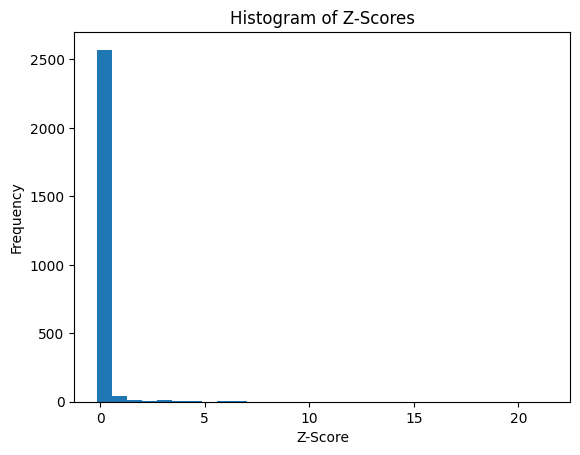

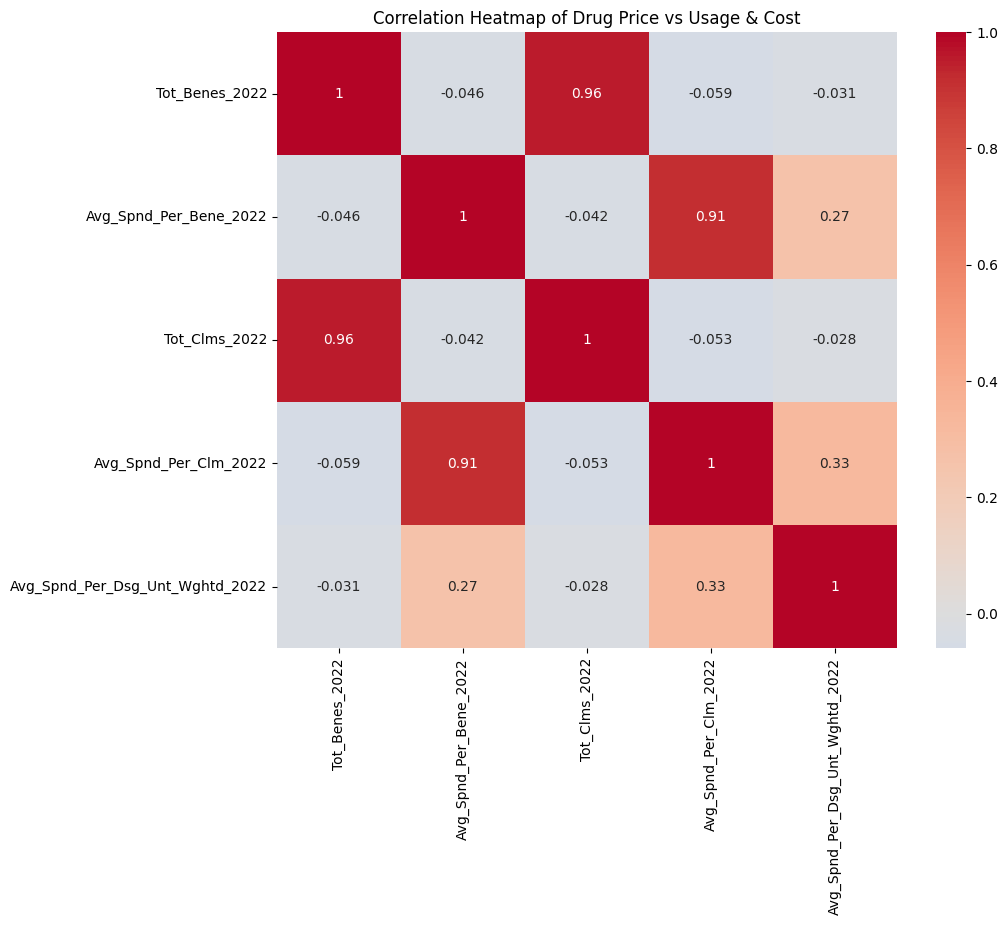

<ipython-input-26-b5710440f6bc>:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-26-b5710440f6bc>:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-26-b5710440f6bc>:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


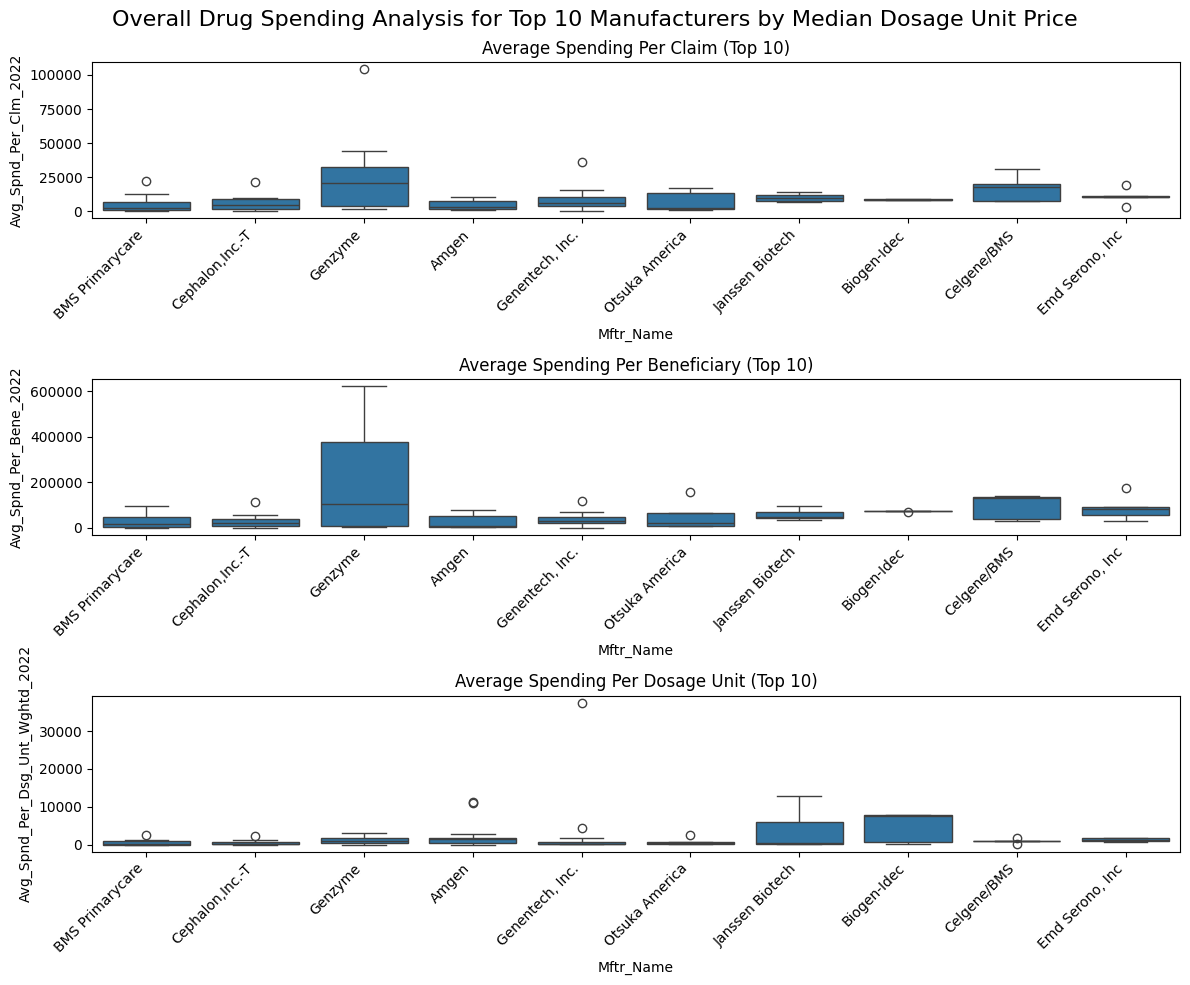

Mftr_Name
Biogen-Idec        7646.644254
Amgen              1508.157121
Emd Serono, Inc    1218.941323
Celgene/BMS        1009.793631
Genzyme             914.759968
B.Braun               0.007355
Baxter Healthca       0.051120
Rite Aid Corp.        0.083202
Covidien/Kendal       0.086830
Morton Grove Ph       0.114671
Name: Avg_Spnd_Per_Dsg_Unt_Wghtd_2022, dtype: float64


<ipython-input-26-b5710440f6bc>:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-26-b5710440f6bc>:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
<ipython-input-26-b5710440f6bc>:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


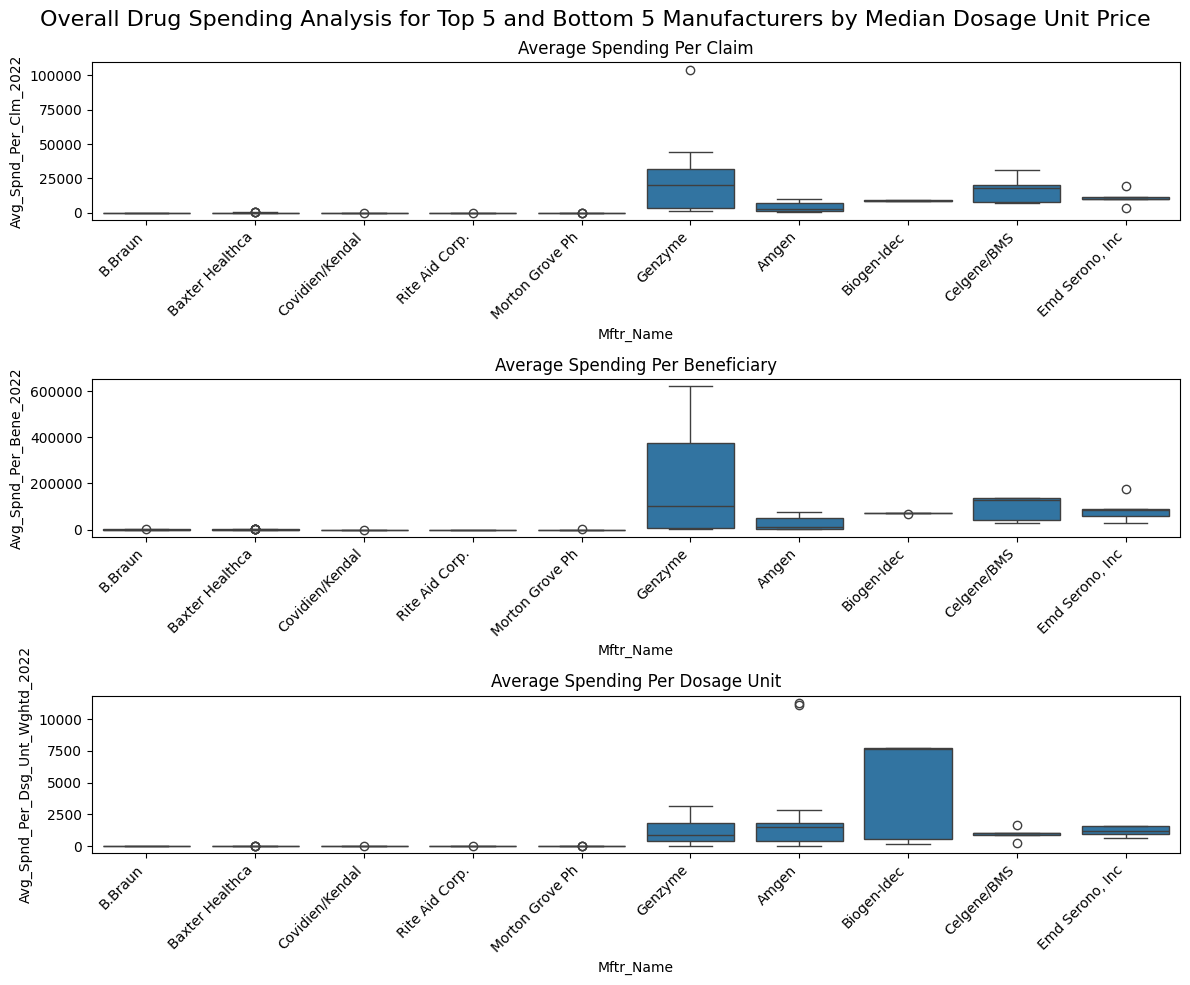

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5728.
  res = hypotest_fun_out(*samples, **kwds)


             Tot_Benes_2022_Skewness Avg_Spnd_Per_Bene_2022_Skewness  \
Manufacturer                     AHP                    Actavis/Teva   

             Tot_Clms_2022_Skewness Avg_Spnd_Per_Clm_2022_Skewness  \
Manufacturer                  Mylan                          Mylan   

             Tot_Dsg_Unts_2022_Skewness Tot_Spndng_2022_Skewness  \
Manufacturer                        AHP                 Teva USA   

             CAGR_Avg_Spnd_Per_Dsg_Unt_18_22_Skewness  
Manufacturer                              Apotex Corp  


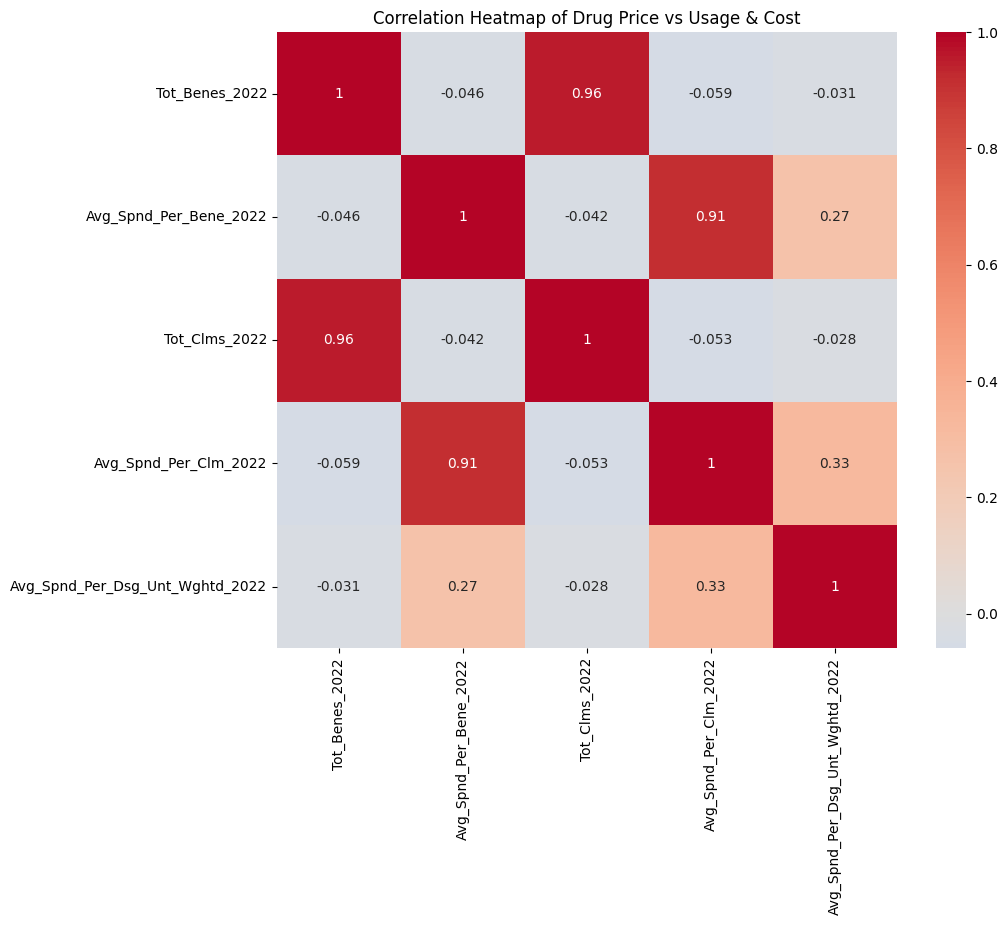

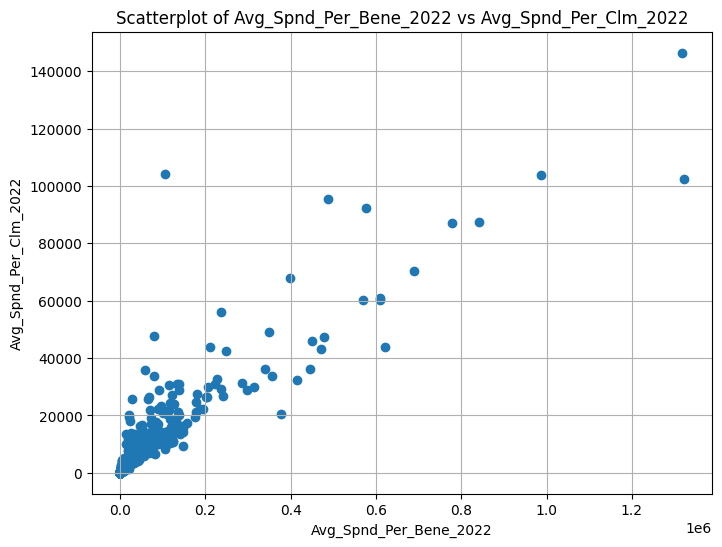

In [ ]:
def main():

  # Part 1:
  link = "/content/drive/My Drive/Medicare_Part_D_Spending_by_Drug_2022.csv"
  df = convert_data(link)
  print(df.head())
  cleaned_df = clean_dataset(df) # All rows with NaN values are removed
  filtered_df = filter_entries(cleaned_df) # Mftr_Name == "Overall"
  filtered_df.head()

  # Part 2:
  mylist = weighted_year_columnNum( filtered_df )
  # print(mylist)
  normalized_df = normalize_prices( filtered_df, mylist )
  print(normalized_df.iloc[0,:])
  distance_df = cosine_matrix( normalized_df )
  print(distance_df.index.is_unique) # should be True
  print(distance_df.columns.is_unique) # should be True
  kNN_df = tot_kNN_similarity( normalized_df, 5 ) # kNN = 5

  # Part 3:
  CAGR_df = extract_CAGR( filtered_df ) # Not used in final run, but kept as a practice function
  converted_dflist = find_convert_data( filtered_df )
  print(converted_dflist[0])
  predicted_values = calculate_dosage( converted_dflist )

  # Part 4:
  outlier_df = outlier_detection( filtered_df )
  plot_zscores( filtered_df )
  plot_heatmap( filtered_df )
  above5_df = df_above5( cleaned_df )
  p_value = kruskal_wallis_htest( above5_df )
  plot_boxplots_top10( cleaned_df )
  plot_boxplots_topbot5( cleaned_df )

  # Part 5:
  df1 = determine_all_normality( cleaned_df )
  df2 = determine_selected_normality( cleaned_df )
  df3 = determine_skewness_by_manu( cleaned_df )
  df4 = highest_skewness( df3 )
  print(df4)
  plot_heatmap( filtered_df )
  plot_features( filtered_df, "Avg_Spnd_Per_Clm_2022")
  return

main()

In [ ]:
import unittest

# convert_data, clean_dataset, filter_entries, weighted_column, normalize_prices,


class Test_cleandataset(unittest.TestCase):

  # check if clean_dataset returns a dataframe
  def test_clean_dataset_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Brnd_Name": ["DrugA", "DrugB", "DrugC"],
    "Norm_2018": [1.0, 0.9, None],
    "Norm_2019": [1.1, 0.85, 0.25],
    "Norm_2020": [0.95, None, 0.3],
    "Norm_2021": [1.05, 0.9, 0.35],
    "Norm_2022": [1.0, 0.88, 0.4]})

    testcase2 = pd.DataFrame({
    "Brnd_Name": ["DrugA", "DrugB", "DrugC", "DrugD"],
    "Norm_2018": [0.5, 0.52, 1.0, 0.1],
    "Norm_2019": [0.48, 0.5, 1.05, 0.15],
    "Norm_2020": [None, 0.51, 0.95, 0.2],
    "Norm_2021": [0.49, 0.53, 1.1, 0.12],
    "Norm_2022": [0.5, 0.5, None, 0.18]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(clean_dataset( testcase1 ), pd.DataFrame) == True, "clean_dataset should return a dataframe")
    self.assertTrue(isinstance(clean_dataset( testcase2 ), pd.DataFrame) == True, "clean_dataset should return a dataframe")

  # check if clean_dataset returns the correct shape
  def test_clean_dataset_shape( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Brnd_Name": ["DrugA", "DrugB", "DrugC"],
    "Norm_2018": [1.0, 0.9, None],
    "Norm_2019": [1.1, 0.85, 0.25],
    "Norm_2020": [0.95, None, 0.3],
    "Norm_2021": [1.05, 0.9, 0.35],
    "Norm_2022": [1.0, 0.88, 0.4]})

    testcase2 = pd.DataFrame({
    "Brnd_Name": ["DrugA", "DrugB", "DrugC", "DrugD"],
    "Norm_2018": [0.5, 0.52, 1.0, 0.1],
    "Norm_2019": [0.48, 0.5, 1.05, 0.15],
    "Norm_2020": [None, 0.51, 0.95, 0.2],
    "Norm_2021": [0.49, 0.53, 1.1, 0.12],
    "Norm_2022": [0.5, 0.5, None, 0.18]})

    # Tests if output is the correct shape
    self.assertTrue(clean_dataset( testcase1 ).shape[0] == 1, "clean_dataset should have only 1 row of data")
    self.assertTrue(clean_dataset( testcase2 ).shape[0] == 2, "clean_dataset should have only 2 rows of data")


class Test_filterentries(unittest.TestCase):

  # check if filter_entries returns a dataframe
  def test_filter_entries_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Mftr_Name": ["Overall", "Mftr1", "Mftr2"],
    "Norm_2018": [1.0, 0.9, 0.7],
    "Norm_2019": [1.1, 0.85, 0.25],
    "Norm_2020": [0.95, 0.76, 0.3],
    "Norm_2021": [1.05, 0.9, 0.35],
    "Norm_2022": [1.0, 0.88, 0.4]})

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["Mftr1", "Overall", "Mftr2", "Overall"],
    "Norm_2018": [0.5, 0.52, 1.0, 0.1],
    "Norm_2019": [0.48, 0.5, 1.05, 0.15],
    "Norm_2020": [0.34, 0.51, 0.95, 0.2],
    "Norm_2021": [0.49, 0.53, 1.1, 0.12],
    "Norm_2022": [0.5, 0.5, 0.23, 0.18]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(filter_entries( testcase1 ), pd.DataFrame) == True, "filter_entries should return a dataframe")
    self.assertTrue(isinstance(filter_entries( testcase2 ), pd.DataFrame) == True, "filter_entries should return a dataframe")

  # check if filter_entries returns the correct shape
  def test_filter_entries_shape( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Mftr_Name": ["Overall", "MftrA", "Overall"],
    "Norm_2018": [1.0, 0.9, 0.82],
    "Norm_2019": [1.1, 0.85, 0.25],
    "Norm_2020": [0.95, 0.43, 0.3],
    "Norm_2021": [1.05, 0.9, 0.35],
    "Norm_2022": [1.0, 0.88, 0.4]})

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["MftrA", "Overall", "MftrB", "MftrC"],
    "Norm_2018": [0.5, 0.52, 1.0, 0.1],
    "Norm_2019": [0.48, 0.5, 1.05, 0.15],
    "Norm_2020": [0.65, 0.51, 0.95, 0.2],
    "Norm_2021": [0.49, 0.53, 1.1, 0.12],
    "Norm_2022": [0.5, 0.5, 0.73, 0.18]})

    # Tests if output is the correct shape
    self.assertTrue(filter_entries( testcase1 ).shape[0] == 2, "filter_entries should return a dataframe with Mftr_Name == 'Overall' ")
    self.assertTrue(filter_entries( testcase2 ).shape[0] == 1, "filter_entries should return a dataframe with Mftr_Name == 'Overall' ")


class Test_weightedyearcolumnNum(unittest.TestCase):

  # check if weighted_year_columnNum returns a float
  def test_weighted_year_columnNum_type( self ):

    # Generate Test Cases
    testcase1 = ["Brnd_Name",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019",
        "Outlier_Flag_2019",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"]

    testcase2 = ["Brnd_Name",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019",
        "Tot_Spndng_2021",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021"]

    testcase1_df = pd.DataFrame(columns=testcase1)
    testcase2_df = pd.DataFrame(columns=testcase2)

    output1 = weighted_year_columnNum(testcase1_df)
    output2 = weighted_year_columnNum(testcase2_df)

    # Tests if output is a float
    self.assertTrue(output1[0] == 1, "weighted_year_columnNum should return a the correct index for Avg_Spnd_Per_Dsg_Unt_Wghtd_2018" )
    self.assertTrue(output2[1] == 1, "weighted_year_columnNum should return a the correct index for Avg_Spnd_Per_Dsg_Unt_Wghtd_2018" )

  # check if weighted_year_columnNum returns the correct value
  def test_weighted_year_columnNum_value( self ):

    # Generate Test Cases
    testcase1 = ["Brnd_Name",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019",
        "Outlier_Flag_2019",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"]

    testcase2 = ["Brnd_Name",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019",
        "Tot_Spndng_2021",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022"
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018",
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021"]

    testcase1_df = pd.DataFrame(columns = testcase1)
    testcase2_df = pd.DataFrame(columns = testcase2)

    output1 = weighted_year_columnNum(testcase1_df)
    output2 = weighted_year_columnNum(testcase2_df)

    # Tests if output is a float
    self.assertTrue(len(output1) == 5, "weighted_year_columnNum should return the correct output length")
    self.assertTrue(len(output1) == 5, "weighted_year_columnNum should return the correct output length")

class Test_normalizeprices(unittest.TestCase):

  # check if normalize_prices returns a dataframe
  def test_normalize_prices_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [16, 20],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [15, 22],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [14, 21],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [11, 19],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [12, 18]})

    testcase2 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [7, 8],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [2, 3],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [1, 3],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [8, 10],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [6, 9]})

    colNumbers = [1,2,3,4,5]
    # Tests if output is a dataframe
    self.assertTrue(isinstance(normalize_prices( testcase1, colNumbers ), pd.DataFrame) == True, "normalize_prices should return a dataframe")
    self.assertTrue(isinstance(normalize_prices( testcase2, colNumbers ), pd.DataFrame) == True, "normalize_prices should return a dataframe" )

  # check if normalize_prices returns the correct column names
  def test_normalize_prices_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Brnd_Name": ["DrugA", "DrugB", "DrugC"],
    "Norm_2018": [1.0, 0.9, 0.2],
    "Norm_2019": [1.1, 0.85, 0.25],
    "Norm_2020": [0.95, 0.8, 0.3],
    "Norm_2021": [1.05, 0.9, 0.35],
    "Norm_2022": [1.0, 0.88, 0.4],})

    testcase2 = pd.DataFrame({
    "Brnd_Name": ["DrugA", "DrugB", "DrugC", "DrugD"],
    "Norm_2018": [0.5, 0.52, 1.0, 0.1],
    "Norm_2019": [0.48, 0.5, 1.05, 0.15],
    "Norm_2020": [0.47, 0.51, 0.95, 0.2],
    "Norm_2021": [0.49, 0.53, 1.1, 0.12],
    "Norm_2022": [0.5, 0.5, 1.0, 0.18]})

    colNumbers = [1,2,3,4,5]
    colNames = ["Brnd_Name", "Norm_2018", "Norm_2019", "Norm_2020", "Norm_2021", "Norm_2022"]

    # Tests if output contains correct column names
    self.assertTrue(list(normalize_prices( testcase1, colNumbers ).columns) == colNames, "Column names are incorrect")
    self.assertTrue(list(normalize_prices( testcase1, colNumbers ).columns) == colNames, "Column names are incorrect")

class Test_onekNNsimilarity(unittest.TestCase):

  # check if one_kNN_similarity returns the correct length
  def test_one_kNN_similarity_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"DrugX": [0.5, 0.52, 1.0, 0.1],
        "DrugY": [0.48, 0.5, 1.05, 0.15],
        "DrugZ": [0.47, 0.51, 0.95, 0.2],
        "DrugW": [0.49, 0.53, 1.1, 0.12]}, index=["DrugX", "DrugY", "DrugZ", "DrugW"])

    testcase2 = pd.DataFrame({"DrugM": [0.7, 0.2, 0.75, 0.3, 0.9],
    "DrugN": [0.72, 0.22, 0.7, 0.28, 0.95],
    "DrugO": [0.68, 0.19, 0.8, 0.35, 0.92],
    "DrugP": [0.69, 0.2, 0.78, 0.32, 0.89],
    "DrugQ": [0.7, 0.21, 0.76, 0.31, 0.91]}, index=["DrugM", "DrugN", "DrugO", "DrugP", "DrugQ"])

    kneighbors1 = one_kNN_similarity(testcase1, "DrugX", 2)
    kneighbors2 = one_kNN_similarity(testcase2, "DrugM", 2)

    # Tests if output is the correct length
    self.assertTrue(len(kneighbors1) == 2, "Length of output should be 2")
    self.assertTrue(len(kneighbors1) == 2, "Length of output should be 2")

  # check if one_kNN_similarity returns the correct k-neighbors
  def test_one_kNN_similarity_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"DrugX": [0.5, 0.52, 1.0, 0.1],
        "DrugY": [0.48, 0.5, 1.05, 0.15],
        "DrugZ": [0.47, 0.51, 0.95, 0.2],
        "DrugW": [0.49, 0.53, 1.1, 0.12]}, index=["DrugX", "DrugY", "DrugZ", "DrugW"])

    testcase2 = pd.DataFrame({"DrugM": [0.7, 0.2, 0.75, 0.3, 0.9],
    "DrugN": [0.72, 0.22, 0.7, 0.28, 0.95],
    "DrugO": [0.68, 0.19, 0.8, 0.35, 0.92],
    "DrugP": [0.69, 0.2, 0.78, 0.32, 0.89],
    "DrugQ": [0.7, 0.21, 0.76, 0.31, 0.91]}, index=["DrugM", "DrugN", "DrugO", "DrugP", "DrugQ"])

    kneighbors1 = one_kNN_similarity(testcase1, "DrugX", 3)
    kneighbors2 = one_kNN_similarity(testcase2, "DrugM", 4)

    # Ensures the inputted drug is not its own neighbor
    self.assertNotIn("DrugX", kneighbors1, "DrugX should not be its own neighbor")
    self.assertNotIn("DrugM", kneighbors2, "DrugM should not be its own neighbor")

class Test_totkNNsimilarity(unittest.TestCase):

  # check if tot_kNN_similarity returns a dataframe
  def test_tot_kNN_similarity_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Brnd_Name": ["DrugX", "DrugY", "DrugZ", "DrugW"],
        "Norm_2018": [0.5, 0.52, 1.0, 0.1],
        "Norm_2019": [0.48, 0.5, 1.05, 0.15],
        "Norm_2020": [0.47, 0.51, 0.95, 0.2],
        "Norm_2021": [0.49, 0.53, 1.1, 0.12],
        "Norm_2022": [0.5, 0.5, 1.0, 0.18]}, index=["DrugX", "DrugY", "DrugZ", "DrugW"])

    testcase2 = pd.DataFrame({
    "Brnd_Name": ["DrugM", "DrugN", "DrugO", "DrugP", "DrugQ"],
    "Norm_2018": [0.7, 0.2, 0.75, 0.3, 0.9],
    "Norm_2019": [0.72, 0.22, 0.7, 0.28, 0.95],
    "Norm_2020": [0.68, 0.19, 0.8, 0.35, 0.92],
    "Norm_2021": [0.69, 0.2, 0.78, 0.32, 0.89],
    "Norm_2022": [0.7, 0.21, 0.76, 0.31, 0.91]}, index=["DrugM", "DrugN", "DrugO", "DrugP", "DrugQ"])

    kneighbors1 = tot_kNN_similarity(testcase1, 2)
    kneighbors2 = tot_kNN_similarity(testcase2, 2)

    # Tests if output is a dataframe
    self.assertTrue(isinstance(tot_kNN_similarity( testcase1, 2 ), pd.DataFrame) == True, "Function should return a dataframe")
    self.assertTrue(isinstance(tot_kNN_similarity( testcase2, 2 ), pd.DataFrame) == True, "Function should return a dataframe")

  # check if tot_kNN_similarity returns the correct k-neighbors
  def test_tot_kNN_similarity_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Brnd_Name": ["DrugX", "DrugY", "DrugZ", "DrugW"],
        "Norm_2018": [0.5, 0.52, 1.0, 0.1],
        "Norm_2019": [0.48, 0.5, 1.05, 0.15],
        "Norm_2020": [0.47, 0.51, 0.95, 0.2],
        "Norm_2021": [0.49, 0.53, 1.1, 0.12],
        "Norm_2022": [0.5, 0.5, 1.0, 0.18]}, index=["DrugX", "DrugY", "DrugZ", "DrugW"])

    testcase2 = pd.DataFrame({
    "Brnd_Name": ["DrugM", "DrugN", "DrugO", "DrugP", "DrugQ"],
    "Norm_2018": [0.7, 0.2, 0.75, 0.3, 0.9],
    "Norm_2019": [0.72, 0.22, 0.7, 0.28, 0.95],
    "Norm_2020": [0.68, 0.19, 0.8, 0.35, 0.92],
    "Norm_2021": [0.69, 0.2, 0.78, 0.32, 0.89],
    "Norm_2022": [0.7, 0.21, 0.76, 0.31, 0.91]}, index=["DrugM", "DrugN", "DrugO", "DrugP", "DrugQ"])

    kneighbors1 = tot_kNN_similarity(testcase1, 2)
    kneighbors2 = tot_kNN_similarity(testcase2, 2)

    # Ensures the inputted drug is not its own neighbor
    self.assertTrue("DrugX" not in kneighbors1.iloc[0,:], "DrugX should not be its own neighbor")
    self.assertTrue("DrugM" not in kneighbors2.iloc[0,:], "DrugM should not be its own neighbor")


class Test_extractCAGR(unittest.TestCase):

  # check if extract_CAGR returns an integer
  def test_extract_CAGR_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [16, 20],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [15, 22],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [14, 21],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [11, 19],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [12, 18]})

    testcase2 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [7, 8],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [2, 3],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [1, 3],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [8, 10],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [6, 9]})

    # Tests if output is an integer
    self.assertTrue(type(extract_CAGR( testcase1 )) == int, "extract_CAGR should return an integer")
    self.assertTrue(type(extract_CAGR( testcase2 )) == int, "extract_CAGR should return an integer")

  # check if filter_entries returns the correct integer
  def test_extract_CAGR_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [16, 20],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [15, 22],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [14, 21],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [11, 19],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [12, 18]})

    testcase2 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [7, 8],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [2, 3],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [1, 3],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [8, 10],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [6, 9]})

    # Tests if function returns correct output (integer)
    self.assertTrue(extract_CAGR( testcase1 ) == 4, "extract_CAGR should return 4")
    self.assertTrue(extract_CAGR( testcase2 ) == 2, "extract_CAGR should return 2")


class Test_findconvertdata(unittest.TestCase):

  # check if find_convert_data returns a list
  def test_find_convert_data_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Brnd_Name": ["DrugA"],
        "Avg_Spnd_Per_Clm_2018": [100],
        "Avg_Spnd_Per_Bene_2018": [200],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [10],
        "Avg_Spnd_Per_Clm_2019": [110],
        "Avg_Spnd_Per_Bene_2019": [210],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [11],
        "Avg_Spnd_Per_Clm_2020": [120],
        "Avg_Spnd_Per_Bene_2020": [220],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [12],
        "Avg_Spnd_Per_Clm_2021": [130],
        "Avg_Spnd_Per_Bene_2021": [230],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [13],
        "Avg_Spnd_Per_Clm_2022": [140],
        "Avg_Spnd_Per_Bene_2022": [240],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [14],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [0.05]
    })

    testcase2 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Clm_2018": [100, 200],
        "Avg_Spnd_Per_Bene_2018": [300, 400],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [10, 20],
        "Avg_Spnd_Per_Clm_2019": [110, 210],
        "Avg_Spnd_Per_Bene_2019": [310, 410],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [11, 21],
        "Avg_Spnd_Per_Clm_2020": [120, 220],
        "Avg_Spnd_Per_Bene_2020": [320, 420],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [12, 22],
        "Avg_Spnd_Per_Clm_2021": [130, 230],
        "Avg_Spnd_Per_Bene_2021": [330, 430],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [13, 23],
        "Avg_Spnd_Per_Clm_2022": [140, 240],
        "Avg_Spnd_Per_Bene_2022": [340, 440],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [14, 24],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [0.05, 0.06]
    })

    # Tests if output is a list
    self.assertTrue(type(find_convert_data( testcase1 )) == list, "find_convert_data should return a list")
    self.assertTrue(type(find_convert_data( testcase2 )) == list, "find_convert_data should return a list")

  # check if filter_entries returns the correct years
  def test_find_convert_data_years( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Brnd_Name": ["DrugA"],
        "Avg_Spnd_Per_Clm_2018": [100],
        "Avg_Spnd_Per_Bene_2018": [200],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [10],
        "Avg_Spnd_Per_Clm_2019": [110],
        "Avg_Spnd_Per_Bene_2019": [210],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [11],
        "Avg_Spnd_Per_Clm_2020": [120],
        "Avg_Spnd_Per_Bene_2020": [220],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [12],
        "Avg_Spnd_Per_Clm_2021": [130],
        "Avg_Spnd_Per_Bene_2021": [230],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [13],
        "Avg_Spnd_Per_Clm_2022": [140],
        "Avg_Spnd_Per_Bene_2022": [240],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [14],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [0.05]
    })

    testcase2 = pd.DataFrame({
        "Brnd_Name": ["DrugA", "DrugB"],
        "Avg_Spnd_Per_Clm_2018": [100, 200],
        "Avg_Spnd_Per_Bene_2018": [300, 400],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2018": [10, 20],
        "Avg_Spnd_Per_Clm_2019": [110, 210],
        "Avg_Spnd_Per_Bene_2019": [310, 410],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2019": [11, 21],
        "Avg_Spnd_Per_Clm_2020": [120, 220],
        "Avg_Spnd_Per_Bene_2020": [320, 420],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2020": [12, 22],
        "Avg_Spnd_Per_Clm_2021": [130, 230],
        "Avg_Spnd_Per_Bene_2021": [330, 430],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021": [13, 23],
        "Avg_Spnd_Per_Clm_2022": [140, 240],
        "Avg_Spnd_Per_Bene_2022": [340, 440],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [14, 24],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [0.05, 0.06]
    })

    # Tests if each dataframe in the output includes the correct years
    self.assertTrue(find_convert_data( testcase1 )[0]["Year"].to_list() == [2018, 2019, 2020, 2021, 2022], "extract_CAGR should return the correct years")
    self.assertTrue(find_convert_data( testcase2 )[0]["Year"].to_list() == [2018, 2019, 2020, 2021, 2022], "extract_CAGR should return the correct years")



class Test_calculatedosage(unittest.TestCase):

  # check if calculate_dosage returns a dataframe
  def test_calculate_dosage_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Drug Name": ["DrugA", "DrugA", "DrugA", "DrugA", "DrugA"],
        "Year": [2018, 2019, 2020, 2021, 2022],
        "Per Claim": [100, 105, 110, 120, 125],
        "Per Beneficiary": [200, 210, 220, 230, 240],
        "Per Dosage": [10, 11, 12, 13, 14],
        "CAGR": [0.05, 0.05, 0.05, 0.05, 0.05]})

    testcase2 = pd.DataFrame({
        "Drug Name": ["DrugB", "DrugB", "DrugB", "DrugB", "DrugB"],
        "Year": [2018, 2019, 2020, 2021, 2022],
        "Per Claim": [50, 52, 55, 60, 62],
        "Per Beneficiary": [100, 105, 110, 120, 125],
        "Per Dosage": [5, 5.5, 6, 6.5, 7],
        "CAGR": [0.04, 0.04, 0.04, 0.04, 0.04]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(calculate_dosage( [testcase1] ), pd.DataFrame) == True, "calculate_dosage should return a dataframe")
    self.assertTrue(isinstance(calculate_dosage( [testcase2] ), pd.DataFrame) == True, "calculate_dosage should return a dataframe")

  # check if calculate_dosage returns the correct column names
  def test_calculate_dosage_names( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Drug Name": ["DrugA", "DrugA", "DrugA", "DrugA", "DrugA"],
        "Year": [2018, 2019, 2020, 2021, 2022],
        "Per Claim": [100, 105, 110, 120, 125],
        "Per Beneficiary": [200, 210, 220, 230, 240],
        "Per Dosage": [10, 11, 12, 13, 14],
        "CAGR": [0.05, 0.05, 0.05, 0.05, 0.05]})

    testcase2 = pd.DataFrame({
        "Drug Name": ["DrugB", "DrugB", "DrugB", "DrugB", "DrugB"],
        "Year": [2018, 2019, 2020, 2021, 2022],
        "Per Claim": [50, 52, 55, 60, 62],
        "Per Beneficiary": [100, 105, 110, 120, 125],
        "Per Dosage": [5, 5.5, 6, 6.5, 7],
        "CAGR": [0.04, 0.04, 0.04, 0.04, 0.04]})

    expectedColumns = ["Drug Name", "Model to Predict Claims", "R-Squared Value - Claims",
                     "2023 Claims Prediction", "2024 Claims Prediction",
                     "Model to Predict Beneficiaries", "R-Squared Value - Beneficiaries",
                     "2023 Beneficiary Prediction", "2024 Beneficiary Prediction",
                     "2023 Dosage Prediction", "2024 Dosage Prediction"]

    # Tests if output returns the correct column names
    self.assertTrue(list(calculate_dosage([testcase1])) == expectedColumns, "calculate_dosage should return the correct column names")
    self.assertTrue(list(calculate_dosage([testcase2])) == expectedColumns, "calculate_dosage should return the correct column names")

class Test_predictclaims(unittest.TestCase):

  # check if predict_claims returns a tuple
  def test_predict_claims_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Per Claim": [100, 110, 120, 130, 140]})

    testcase2 = pd.DataFrame({"Per Claim": [50, 50, 50, 50, 50]})


    # Tests if output is a tuple
    self.assertTrue(type(predict_claims(testcase1)) == tuple, "predict_claims should return a tuple")
    self.assertTrue(type(predict_claims(testcase2)) == tuple, "predict_claims should return a tuple")

  # check if third element of each tuple output of predict_claims is an r2 value where 0 <= r2 <= 1
  def test_predict_claims_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Per Claim": [100, 110, 120, 130, 140]})

    testcase2 = pd.DataFrame({"Per Claim": [50, 50, 50, 50, 50]})


    # Tests if third element of each tuple output of predict_claims is an r2 value where 0 <= r2 <= 1
    self.assertTrue(predict_claims(testcase1)[2] >= 0 and predict_claims(testcase1)[2] <= 1, "The third element should be an r2 value within the bounds 0 and 1")
    self.assertTrue(predict_claims(testcase2)[2] >= 0 and predict_claims(testcase2)[2] <= 1, "The third element should be an r2 value within the bounds 0 and 1")

class Test_predictbene(unittest.TestCase):

  # check if predict_bene returns a tuple
  def test_predict_bene_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Per Beneficiary": [100, 110, 120, 130, 140]})

    testcase2 = pd.DataFrame({"Per Beneficiary": [50, 50, 50, 50, 50]})


    # Tests if output is a tuple
    self.assertTrue(type(predict_bene(testcase1)) == tuple, "predict_bene should return a tuple")
    self.assertTrue(type(predict_bene(testcase2)) == tuple, "predict_bene should return a tuple")

  # check if third element of each tuple output of predict_bene is an r2 value where 0 <= r2 <= 1
  def test_predict_bene_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Per Beneficiary": [100, 110, 120, 130, 140]})

    testcase2 = pd.DataFrame({"Per Beneficiary": [50, 50, 50, 50, 50]})


    # Tests if third element of each tuple output of predict_bene is an r2 value where 0 <= r2 <= 1
    self.assertTrue(predict_bene(testcase1)[2] >= 0 and predict_bene(testcase1)[2] <= 1, "The third element should be an r2 value within the bounds 0 and 1")
    self.assertTrue(predict_bene(testcase2)[2] >= 0 and predict_bene(testcase2)[2] <= 1, "The third element should be an r2 value within the bounds 0 and 1")


class Test_predictfuture(unittest.TestCase):

  # check if predict_future returns the correct length
  def test_predict_future_value( self ):

    # Generate Test Cases
    testcase1 = ("mean of timeframe", [50, 48])

    testcase2 = ("exponential", [2, 1])


    # Tests if output is the correct length
    self.assertTrue(len(predict_future(*testcase1)) == 2, "predict_future should return an array of length = 2")
    self.assertTrue(len(predict_future(*testcase2)) == 2, "predict_future should return an array of length = 2")

  # check if predict_future returns an array
  def test_predict_future_type( self ):

   # Generate Test Cases
    testcase1 = ("mean of timeframe", [50, 48])

    testcase2 = ("exponential", [2, 1])

    # Tests if output is an array
    self.assertTrue(isinstance(predict_future( *testcase1 ), np.ndarray) == True, "predict_future should return an array")
    self.assertTrue(isinstance(predict_future( *testcase2 ), np.ndarray) == True, "predict_future should return an array")


class Test_minError(unittest.TestCase):

  # check if minError returns the correct output
  def test_minError_value( self ):

    # Generate Test Cases
    ridge1 = [None, None, 1.0]
    lasso1 = [None, None, 2.0]
    elastic1 = [None, None, 3.0]
    modelName1, listreturn1 = minError(ridge1, lasso1, elastic1)

    ridge2 = [None, None, 2.0]
    lasso2 = [None, None, 1.5]
    elastic2 = [None, None, 2.5]
    modelName2, listreturn2 = minError(ridge2, lasso2, elastic2)

    # Tests if output is correct
    self.assertTrue(modelName1 == "Ridge", "minError returns the wrong model name")
    self.assertTrue(modelName2 == "Lasso", "minError returns the wrong model name")

  # check if minError returns an array
  def test_minError_type( self ):

    # Generate Test Cases
    ridge1 = [None, None, 1.0]
    lasso1 = [None, None, 2.0]
    elastic1 = [None, None, 3.0]
    modelName1, listreturn1 = minError(ridge1, lasso1, elastic1)

    ridge2 = [None, None, 2.0]
    lasso2 = [None, None, 1.5]
    elastic2 = [None, None, 2.5]
    modelName2, listreturn2 = minError(ridge2, lasso2, elastic2)

    # Tests if output is an array
    self.assertTrue(listreturn1 == ridge1, "predict_future should return an array")
    self.assertTrue(listreturn2 == lasso2, "predict_future should return an array")

class Test_calculatezscore(unittest.TestCase):

  # check if minError returns the correct output
  def test_calculate_zscore_value( self ):

    # Generate Test Cases
    sample_data1 = pd.Series([10, 20, 30, 40, 50]) # Mean = 10, Standard Deviation is about 14.142
    expected1 = (10 - 30) / np.std(sample_data1)

    sample_data2 = pd.Series([1, 2, 3, 4, 5]) # Mean = 3, Standard Deviation is about 1.414
    expected2 = (1 - 3) / np.std(sample_data2)

    # Tests if output is correct
    self.assertTrue(calculate_zscore( sample_data1, 0 ) == expected1, "calculate_zscores returns the wrong output")
    self.assertTrue(calculate_zscore( sample_data2, 0 ) == expected2, "calculate_zscores returns the wrong output")

  # check if minError returns a float
  def test_calculate_zscore_type( self ):

    # Generate Test Cases
    sample_data1 = pd.Series([10, 20, 30, 40, 50]) # Mean = 10, Standard Deviation is about 14.142
    expected1 = (10 - 30) / np.std(sample_data1)

    sample_data2 = pd.Series([1, 2, 3, 4, 5]) # Mean = 3, Standard Deviation is about 1.414
    expected2 = (1 - 3) / np.std(sample_data2)

    # Tests if output is a float
    self.assertTrue(type(calculate_zscore( sample_data1, 0)) == float, "calculate_zscores should return a float")
    self.assertTrue(type(calculate_zscore( sample_data2, 0)) == float, "calculate_zscores should return a float")




class Test_outlierdetection(unittest.TestCase):

  # check if outlier_detection returns a list
  def test_outlier_detection_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 12, 11, 9, 200]}, index=["DrugA", "DrugB", "DrugC", "DrugD", "DrugE"])

    testcase2 = pd.DataFrame({"Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 11, 9, 10.5, 9.5]}, index=["DrugA", "DrugB", "DrugC", "DrugD", "DrugE"])

    # Tests if output is a dataframe
    self.assertTrue(type(outlier_detection( testcase1 )) == list, "outlier_detection should return a list")
    self.assertTrue(type(outlier_detection( testcase2 )) == list, "outlier_detection should return a list")

  # check if outlier_detection returns the correct output
  def test_outlier_detection_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [96, 97, 98, 99, 100]}, index=["DrugA", "DrugB", "DrugC", "DrugD", "DrugE"])

    testcase2 = pd.DataFrame({"Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 11, 9, 10.5, 9.5]}, index=["DrugA", "DrugB", "DrugC", "DrugD", "DrugE"])

    # Tests if output is correct
    self.assertTrue(outlier_detection(testcase1) == [], "outlier_detection returns the wrong output (expected was ['DrugE'])")
    self.assertTrue(outlier_detection(testcase1) == [], "outlier_detection returns the wrong output (expected was '[]')")


class Test_dfabove5(unittest.TestCase):

  # check if df_above5 returns a dataframe
  def test_df_above5_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Mftr_Name": ["A", "A", "A", "A", "A", "B", "B", "C"]})

    testcase2 = pd.DataFrame({"Mftr_Name": ["A", "A", "B", "B", "C", "C", "D", "D"]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(df_above5( testcase1 ), pd.DataFrame), "df_above5 should return a dataframe")
    self.assertTrue(isinstance(df_above5( testcase2 ), pd.DataFrame), "df_above5 should return a dataframe")

  # check if df_above5 returns the correct output
  def test_df_above5_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Mftr_Name": ["A", "A", "A", "A", "A", "B", "B", "C"]})

    testcase2 = pd.DataFrame({"Mftr_Name": ["A", "A", "B", "B", "C", "C", "D", "D"]})


    # Tests if output is correct
    self.assertTrue(df_above5( testcase1 ).equals(pd.DataFrame({"Mftr_Name": ["A", "A", "A", "A", "A"]})), "df_above5 should return a dataframe with Mftr_Name == 'A' only")
    self.assertTrue(df_above5( testcase2 ).empty, "df_above5 should return an empty dataframe")

class Test_kruskalwallishtest(unittest.TestCase):

  # check if kruskal_wallis_htest returns a float
  def test_kruskal_wallis_htest_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Mftr_Name": ["A", "A", "B", "B", "C", "C"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 11, 10, 11, 10, 11]
    })

    testcase2 = pd.DataFrame({
        "Mftr_Name": ["A", "A", "B", "B", "C", "C"],
        "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 12, 50, 55, 100, 105]
    })

    # Tests if output is a float
    self.assertTrue(type(kruskal_wallis_htest(testcase1) == float), "kruskal_wallis_htest should return a float")
    self.assertTrue(type(kruskal_wallis_htest(testcase2) == float), "kruskal_wallis_htest should return a float")

  # check if df_above5 returns a p-value in the correct range
  def test_kruskal_wallis_htest_ans( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Mftr_Name": ["A", "A", "B", "B", "C", "C"],
    "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 11, 10, 11, 10, 11]})

    testcase2 = pd.DataFrame({"Mftr_Name": ["A", "A", "A", "A", "A", "B", "B", "B", "B", "B", "C", "C", "C", "C", "C"],
    "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022": [10, 11, 9, 12, 8, 100, 105, 110, 98, 102, 200, 210, 220, 205, 215]})

    # Tests if output p-value is in the correct range
    self.assertTrue(kruskal_wallis_htest( testcase1 ) >= 0.05, "kruskal_wallis_htest should return a p-value >= 0.05")
    self.assertTrue(kruskal_wallis_htest( testcase2 ) <= 0.05, "kruskal_wallis_htest should return a p-value <= 0.05")

class Test_dfabove30(unittest.TestCase):

  # check if df_above30 returns a dataframe
  def test_df_above30_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "B", "B", "C"]})

    testcase2 = pd.DataFrame({"Mftr_Name": ["A", "A", "B", "B", "C", "C", "D", "D"]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(df_above30( testcase1 ), pd.DataFrame), "df_above30 should return a dataframe")
    self.assertTrue(isinstance(df_above30( testcase2 ), pd.DataFrame), "df_above30 should return a dataframe")

  # check if df_above30 returns the correct output
  def test_df_above30_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({"Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A",  "B", "B", "C"]})

    testcase2 = pd.DataFrame({"Mftr_Name": ["A", "A", "B", "B", "C", "C", "D", "D"]})


    # Tests if output is correct
    self.assertTrue(df_above30(testcase1)["Mftr_Name"].nunique() == 1 and df_above30(testcase1)["Mftr_Name"].iloc[0] == "A", "df_above30 should return a dataframe with Mftr_Name == 'A' only")
    self.assertTrue(df_above30(testcase2).empty, "df_above30 should return an empty dataframe")


class Test_mftrdataset(unittest.TestCase):

  # check if mftr_dataset returns a dataframe
  def test_mftr_dataset_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Mftr_Name": ["A", "B", "A", "C", "B"],
        "CAGR": [1, 2, 3, 4, 5]})

    testcase2 = pd.DataFrame({
        "Mftr_Name": ["D", "B", "S", "C", "L"],
        "CAGR": [4, 1, 2, 5, 7]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(mftr_dataset(testcase1, "A"), pd.DataFrame), "mftr_dataset should return a dataframe")
    self.assertTrue(isinstance(mftr_dataset(testcase2, "A"), pd.DataFrame), "mftr_dataset should return a dataframe")

  # check if mftr_dataset returns the correct manufacturer
  def test_mftr_dataset_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Mftr_Name": ["A", "B", "A", "C", "B"],
        "CAGR": [1, 2, 3, 4, 5]})

    testcase2 = pd.DataFrame({
        "Mftr_Name": ["D", "B", "S", "C", "L"],
        "CAGR": [4, 1, 2, 5, 7]})

    # Tests if output returns the correct manufacturer name
    self.assertTrue((mftr_dataset(testcase1, "A")["Mftr_Name"] == "A").all(), "output of mftr_dataset includes the wrong manufacturer name")
    self.assertTrue(mftr_dataset(testcase2, "A").empty, "output of mftr_dataset should be empty")

class Test_determineallnormality(unittest.TestCase):

  # check if determine_all_normality returns a dataframe
  def test_determine_all_normality_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
        "Tot_Benes_2022": [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
        "Avg_Spnd_Per_Bene_2022": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
        "Tot_Clms_2022": [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
        "Avg_Spnd_Per_Clm_2022": [50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
        "Tot_Dsg_Unts_2022": [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
        "Tot_Spndng_2022": [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]}) # p-value = 1.0 since all data is identical

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1000],
    "Avg_Spnd_Per_Bene_2022": [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2, 2,2,2,2,2,2,2,2,2,2000],
    "Tot_Clms_2022": [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3000],
    "Avg_Spnd_Per_Clm_2022": [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4000],
    "Tot_Dsg_Unts_2022": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5000],
    "Tot_Spndng_2022": [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6000],
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7000]})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(determine_all_normality(testcase1), pd.DataFrame), "determine_all_normality should return a dataframe")
    self.assertTrue(isinstance(determine_all_normality(testcase2), pd.DataFrame), "determine_all_normality should return a dataframe")

  # check if determine_all_normality returns the correct "normality"
  def test_determine_all_normality_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
        "Tot_Benes_2022": [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
        "Avg_Spnd_Per_Bene_2022": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
        "Tot_Clms_2022": [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
        "Avg_Spnd_Per_Clm_2022": [50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
        "Tot_Dsg_Unts_2022": [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
        "Tot_Spndng_2022": [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000],
        "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]}) # p-value = 1.0 since all data is identical

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1000],
    "Avg_Spnd_Per_Bene_2022": [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2, 2,2,2,2,2,2,2,2,2,2000],
    "Tot_Clms_2022": [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3000],
    "Avg_Spnd_Per_Clm_2022": [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4000],
    "Tot_Dsg_Unts_2022": [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5000],
    "Tot_Spndng_2022": [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6000],
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": [7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7000]})

    # Tests if output returns the correct "normality"
    self.assertTrue((determine_all_normality(testcase1).loc["Normality"] == "normal").all(), "determine_all_normality should include 'normal'")
    self.assertTrue((determine_all_normality(testcase2).loc["Normality"] == "non-normal").all(), "determine_all_normality should include 'normal'")


class Test_determineselectednormality(unittest.TestCase):

  # check if determine_selected_normality returns a dataframe
  def test_determine_selected_normality_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    "Tot_Benes_2022": np.random.normal(1000, 50, 30), # ChatGPT recommended using np.random.normal for this test
    "Avg_Spnd_Per_Bene_2022": np.random.normal(500, 20, 30),
    "Tot_Clms_2022": np.random.normal(100, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(50, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(5000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(20000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.05, 0.01, 30)})

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": np.random.normal(1200, 50, 30),
    "Avg_Spnd_Per_Bene_2022": np.random.normal(600, 20, 30),
    "Tot_Clms_2022": np.random.normal(150, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(75, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(7000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(24000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.04, 0.02, 30)})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(determine_selected_normality(testcase1), pd.DataFrame), "determine_selected_normality should return a dataframe")
    self.assertTrue(isinstance(determine_selected_normality(testcase2), pd.DataFrame), "determine_selected_normality should return a dataframe")

  # check if determine_selected_normality returns the correct "normality"
  def test_determine_selected_normality_value( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    "Tot_Benes_2022": np.random.normal(1000, 50, 30), # ChatGPT recommended using np.random.normal for this test
    "Avg_Spnd_Per_Bene_2022": np.random.normal(500, 20, 30),
    "Tot_Clms_2022": np.random.normal(100, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(50, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(5000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(20000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.05, 0.01, 30)})

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": np.random.normal(1200, 50, 30),
    "Avg_Spnd_Per_Bene_2022": np.random.normal(600, 20, 30),
    "Tot_Clms_2022": np.random.normal(150, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(75, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(7000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(24000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.04, 0.02, 30)})

    # Tests if output returns the correct "normality"
    self.assertTrue(len(determine_selected_normality(testcase1).index) == 1, "determine_selected_normality should return one row for manufacturer 'A'")
    self.assertTrue(len(determine_selected_normality(testcase2).index) == 1, "determine_selected_normality should return one row for manufacturer 'A'")


class Test_determineskewnessbymanu(unittest.TestCase):

  # check if determine_skewness_by_manu returns a dataframe
  def test_determine_skewness_by_manu_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Mftr_Name": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A"],
    "Tot_Benes_2022": np.random.normal(1000, 50, 30),
    "Avg_Spnd_Per_Bene_2022": np.random.normal(500, 20, 30),
    "Tot_Clms_2022": np.random.normal(100, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(50, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(5000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(20000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.05, 0.01, 30)})

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": np.random.normal(1200, 50, 30),
    "Avg_Spnd_Per_Bene_2022": np.random.normal(600, 20, 30),
    "Tot_Clms_2022": np.random.normal(150, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(75, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(7000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(24000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.04, 0.02, 30)})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(determine_skewness_by_manu(testcase1), pd.DataFrame), "determine_skewness_by_manu should return a dataframe")
    self.assertTrue(isinstance(determine_skewness_by_manu(testcase2), pd.DataFrame), "determine_skewness_by_manu should return a dataframe")

  # check if determine_skewness_by_manu returns the correct shape
  def test_determine_skewness_by_manu_shape( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": np.random.normal(1000, 50, 30),
    "Avg_Spnd_Per_Bene_2022": np.random.normal(500, 20, 30),
    "Tot_Clms_2022": np.random.normal(100, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(50, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(5000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(20000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.05, 0.01, 30)})

    testcase2 = pd.DataFrame({
    "Mftr_Name": ["X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X", "X"],
    "Tot_Benes_2022": np.random.normal(1200, 50, 30),
    "Avg_Spnd_Per_Bene_2022": np.random.normal(600, 20, 30),
    "Tot_Clms_2022": np.random.normal(150, 5, 30),
    "Avg_Spnd_Per_Clm_2022": np.random.normal(75, 5, 30),
    "Tot_Dsg_Unts_2022": np.random.normal(7000, 200, 30),
    "Tot_Spndng_2022": np.random.normal(24000, 1000, 30),
    "CAGR_Avg_Spnd_Per_Dsg_Unt_18_22": np.random.normal(0.04, 0.02, 30)})

    # Tests if output returns the correct shape
    self.assertTrue(determine_skewness_by_manu(testcase1).shape[0] == 1, "determine_skewness_by_manu should include have 1 row")
    self.assertTrue(determine_skewness_by_manu(testcase2).shape[0] == 1, "determine_skewness_by_manu should include have 1 row")

class Test_highestskewness(unittest.TestCase):

  # check if highest_skewness returns a dataframe
  def test_highest_skewness_type( self ):

    # Generate Test Cases
    testcase1 = pd.DataFrame({
        "Feature1": {"M1": 0.2, "M2": 2.5, "M3": 1.0},
        "Feature2": {"M1": -3.0, "M2": 0.5, "M3": 1.2}})

    testcase2 = pd.DataFrame({
        "Feature1": {"M1": 2.0, "M2": -2.0, "M3": 1.5},
        "Feature2": {"M1": 0.5, "M2": 0.5, "M3": -0.5}})

    # Tests if output is a dataframe
    self.assertTrue(isinstance(highest_skewness(testcase1), pd.DataFrame), "highest_skewness should return a dataframe")
    self.assertTrue(isinstance(highest_skewness(testcase2), pd.DataFrame), "highest_skewness should return a dataframe")

  # check if highest_skewness returns the currect manufacturer
  def test_highest_skewness_value( self ):

    # Generate Test Cases
    # Generate Test Cases
    testcase1 = pd.DataFrame({
    "Feature1": {"M1":  0.2, "M2": 10.0, "M3": 1.0},
    "Feature2": {"M1": -3.0, "M2": 0.5, "M3": 1.2}})

    testcase2 = pd.DataFrame({
    "Feature1": {"M1": 2.0, "M2": -2.0, "M3": 1.5},
    "Feature2": {"M1": 3.5, "M2": 0.5, "M3": -0.5}})

    # Tests if output returns the correct manufacturer
    self.assertTrue(highest_skewness(testcase1).loc["Manufacturer", "Feature1"] == "M2", "highest_skewness should return 'M2'")
    self.assertTrue(highest_skewness(testcase2).loc["Manufacturer", "Feature2"] == "M1", "highest_skewness should return 'M1'")



unittest.main(argv=[''], verbosity = 2, exit = False)


test_calculate_dosage_names (__main__.Test_calculatedosage.test_calculate_dosage_names) ... /usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


  Drug Name Model to Predict Claims  R-Squared Value - Claims  \
0     DrugA       mean of timeframe                         0   

   2023 Claims Prediction  2024 Claims Prediction  \
0                   112.0                   112.0   

  Model to Predict Beneficiaries  R-Squared Value - Beneficiaries  \
0              mean of timeframe                                0   

   2023 Beneficiary Prediction  2024 Beneficiary Prediction  \
0                        220.0                        220.0   

   2023 Dosage Prediction  2024 Dosage Prediction  
0               11.998243               11.998243  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


  Drug Name Model to Predict Claims  R-Squared Value - Claims  \
0     DrugB       mean of timeframe                         0   

   2023 Claims Prediction  2024 Claims Prediction  \
0                    55.8                    55.8   

  Model to Predict Beneficiaries  R-Squared Value - Beneficiaries  \
0              mean of timeframe                                0   

   2023 Beneficiary Prediction  2024 Beneficiary Prediction  \
0                        112.0                        112.0   

   2023 Dosage Prediction  2024 Dosage Prediction  
0                5.993702                5.993702  


ok
test_calculate_dosage_type (__main__.Test_calculatedosage.test_calculate_dosage_type) ... /usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


  Drug Name Model to Predict Claims  R-Squared Value - Claims  \
0     DrugA       mean of timeframe                         0   

   2023 Claims Prediction  2024 Claims Prediction  \
0                   112.0                   112.0   

  Model to Predict Beneficiaries  R-Squared Value - Beneficiaries  \
0              mean of timeframe                                0   

   2023 Beneficiary Prediction  2024 Beneficiary Prediction  \
0                        220.0                        220.0   

   2023 Dosage Prediction  2024 Dosage Prediction  
0               11.998243               11.998243  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


  Drug Name Model to Predict Claims  R-Squared Value - Claims  \
0     DrugB       mean of timeframe                         0   

   2023 Claims Prediction  2024 Claims Prediction  \
0                    55.8                    55.8   

  Model to Predict Beneficiaries  R-Squared Value - Beneficiaries  \
0              mean of timeframe                                0   

   2023 Beneficiary Prediction  2024 Beneficiary Prediction  \
0                        112.0                        112.0   

   2023 Dosage Prediction  2024 Dosage Prediction  
0                5.993702                5.993702  


ok
test_calculate_zscore_type (__main__.Test_calculatezscore.test_calculate_zscore_type) ... ok
test_calculate_zscore_value (__main__.Test_calculatezscore.test_calculate_zscore_value) ... ok
test_clean_dataset_shape (__main__.Test_cleandataset.test_clean_dataset_shape) ... ok
test_clean_dataset_type (__main__.Test_cleandataset.test_clean_dataset_type) ... ok
test_current_values_type (__main__.Test_currentvalues.test_current_values_type) ... ok
test_current_values_value (__main__.Test_currentvalues.test_current_values_value) ... ok
test_determine_all_normality_type (__main__.Test_determineallnormality.test_determine_all_normality_type) ... /usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
ok
test_determine_all_normality_value (__main__.Test_determineallnormality.test_determine_all_normality_value) ... /usr/local/lib/python3.1

ok
test_determine_skewness_by_manu_type (__main__.Test_determineskewnessbymanu.test_determine_skewness_by_manu_type) ... 

ok
test_df_above30_type (__main__.Test_dfabove30.test_df_above30_type) ... ok
test_df_above30_value (__main__.Test_dfabove30.test_df_above30_value) ... ok
test_df_above5_type (__main__.Test_dfabove5.test_df_above5_type) ... ok
test_df_above5_value (__main__.Test_dfabove5.test_df_above5_value) ... ok
test_extract_CAGR_type (__main__.Test_extractCAGR.test_extract_CAGR_type) ... ok
test_extract_CAGR_value (__main__.Test_extractCAGR.test_extract_CAGR_value) ... ok
test_filter_entries_shape (__main__.Test_filterentries.test_filter_entries_shape) ... ok
test_filter_entries_type (__main__.Test_filterentries.test_filter_entries_type) ... ok
test_find_convert_data_type (__main__.Test_findconvertdata.test_find_convert_data_type) ... ok
test_find_convert_data_years (__main__.Test_findconvertdata.test_find_convert_data_years) ... ok
test_highest_skewness_type (__main__.Test_highestskewness.test_highest_skewness_type) ... 

ok
test_highest_skewness_value (__main__.Test_highestskewness.test_highest_skewness_value) ... 

ok
test_kruskal_wallis_htest_ans (__main__.Test_kruskalwallishtest.test_kruskal_wallis_htest_ans) ... ok
test_kruskal_wallis_htest_type (__main__.Test_kruskalwallishtest.test_kruskal_wallis_htest_type) ... ok
test_mftr_dataset_type (__main__.Test_mftrdataset.test_mftr_dataset_type) ... ok
test_mftr_dataset_value (__main__.Test_mftrdataset.test_mftr_dataset_value) ... ok
test_minError_type (__main__.Test_minError.test_minError_type) ... ok
test_minError_value (__main__.Test_minError.test_minError_value) ... ok
test_normalize_prices_type (__main__.Test_normalizeprices.test_normalize_prices_type) ... ok
test_normalize_prices_value (__main__.Test_normalizeprices.test_normalize_prices_value) ... ok
test_one_kNN_similarity_type (__main__.Test_onekNNsimilarity.test_one_kNN_similarity_type) ... ok
test_one_kNN_similarity_value (__main__.Test_onekNNsimilarity.test_one_kNN_similarity_value) ... ok
test_outlier_detection_type (__main__.Test_outlierdetection.test_outlier_detection_type) ... ok
tes

ok
test_tot_kNN_similarity_value (__main__.Test_totkNNsimilarity.test_tot_kNN_similarity_value) ... 

ok
test_weighted_year_columnNum_type (__main__.Test_weightedyearcolumnNum.test_weighted_year_columnNum_type) ... ok
test_weighted_year_columnNum_value (__main__.Test_weightedyearcolumnNum.test_weighted_year_columnNum_value) ... ok

----------------------------------------------------------------------
Ran 48 tests in 69.797s

OK
